# PeW Evolution with Phase

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sndata.csp import DR1, DR3
from sndata.utils import convert_to_jd

results_dir = Path('.').resolve().parent / 'results'


## Reading in data

In [3]:
dr3 = DR3()
dr3.download_module_data()


In [4]:
@np.vectorize
def get_csp_t0(obj_id):
    """Get the t0 value for CSP targets

    Args:
        obj_id (str): The object identifier

    Returns:
        The time of B-band maximum in units of
    """

    csp_table_3 = dr3.load_table(3).to_pandas(index='SN')
    
    # Unknown object ID
    if obj_id not in csp_table_3.index:
        return np.nan

    t0_mjd = csp_table_3.loc[obj_id]['T(Bmax)']

    # Known object Id with unknown peak time
    if np.isnan(t0_mjd):
        return np.nan

    return convert_to_jd(t0_mjd)


def calc_branch_class(pw6, pw7):
    """Calculate the branch classification for given pEW
    
    Args:
        pw6 (ndarray): Array of EW measurements for feature 6
        pw7 (ndarray): Array of EW measurements for feature 7
        
    Returns:
        An array of strings
    """
    
    branch_types = np.full_like(pw6, 'CN', dtype='U10')
    branch_types[pw6 > 30] = 'CL' 
    branch_types[(pw6 < 30) & (pw7 > 105)] = 'BL' 
    branch_types[pw7 < 70] = 'SS'  
    return pd.Series(branch_types, index=pw6.index, name='class')


def read_in_pipeline_result(path):
    """Read pEW values from analysis pipline file
    
    Adds columns for Branch classifications determined by the
    measured pEW values and spectral subtypes determined from 
    CSP DR1.
    
    Args:
        path (str): Path of the file to read
        
    Returns:
        A pandas Dataframe indexed by feat_name and obj_id
    """
    
    df = pd.read_csv(path, index_col=['feat_name', 'obj_id'])

    # Add phases using CSP DR3 t0 values
    obj_id = df.index.get_level_values(1)
    df['phase'] = get_csp_t0(obj_id) - df.time

    # Add Branch style classifications
    pw = pd.DataFrame({
        'pW6': df.loc['pW6'].pew, 
        'pW7': df.loc['pW7'].pew}
    ).dropna()
    df = df.join(calc_branch_class(pw.pW6, pw.pW7), on='obj_id')
    
    # Add spectral subtypes
    csp_table_2 = dr3.load_table(2)
    subtypes = pd.DataFrame({'spec_type': csp_table_2['Subtype1']}, index=csp_table_2['SN'])
    df = df.join(subtypes, on='obj_id')
    
    return df



In [5]:
ella = read_in_pipeline_result(results_dir / 'ella_csp.csv')
emily = read_in_pipeline_result(results_dir / 'emily_csp.csv')
anish = read_in_pipeline_result(results_dir / 'anish_csp.csv')


## Pew Vs. Phase

In [6]:
def plot_feat_evolution(df, feat_name, color_by='class', axis=None):
    """Plot the strength of a feature vs phase
    
    Args:
        df  (DataFrame): Dataframe to plot data from
        feat_name (str): Name of the feature (index) to plot
        color_by  (str): Name of the column to color code points by
        axis     (Axis): Optionally plot on a given axis
    """
    
    if axis is None:
        fig, axis = plt.subplots(figsize=(6, 4))

    feature_data = df.loc[feat_name]
    for i, (class_name, class_data) in enumerate(feature_data.groupby(color_by)):
        class_data = class_data.sort_values('phase')
        x = class_data.phase
        y = class_data.pew
        y_err = class_data.pew_samperr

        axis.errorbar(x, y, yerr=y_err, linestyle='', color=f'C{i}')
        axis.scatter(x, y, s=15, label=class_name, color=f'C{i}')
    
    axis.legend()
    axis.set_title(feat_name)
    if axis is None:
        axis.set_xlabel('Phase', fontsize=12)
        axis.set_ylabel(r'pEW ($\AA$)', fontsize=12)
        
    axis.set_xlim(-15, 15)
    

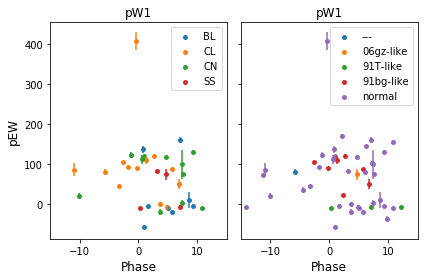

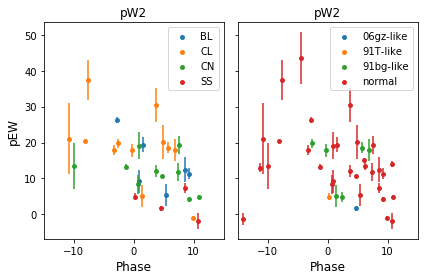

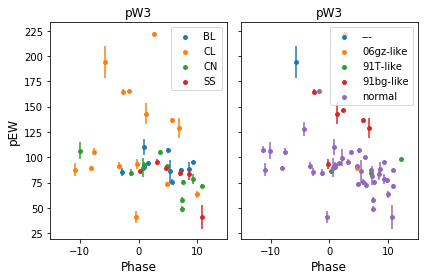

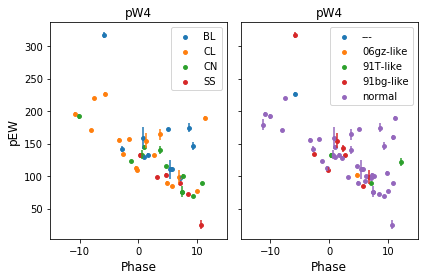

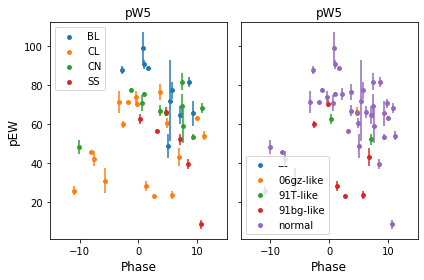

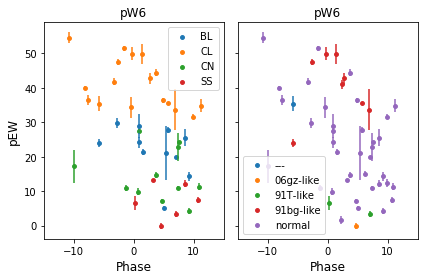

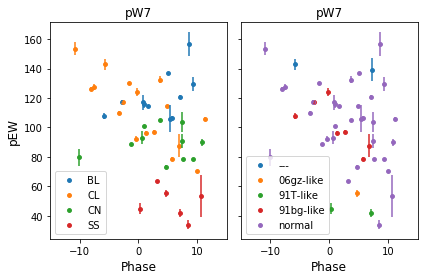

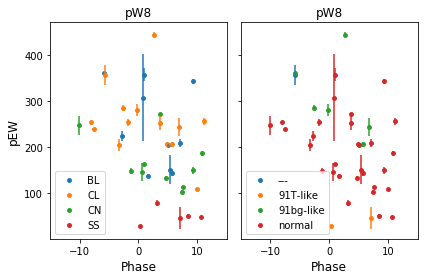

In [8]:
plot_using = anish
plot_features = [f'pW{i}' for i in range(1, 9)]

for feature in plot_features:
    fig, axes = plt.subplots(1, 2, sharey=True)
    for axis, color_by in zip(axes, ('class', 'spec_type')):
        plot_feat_evolution(plot_using, feature, color_by, axis=axis)
        axis.set_xlabel('Phase', fontsize=12)

    axes[0].set_ylabel('pEW', fontsize=12)
    plt.tight_layout()
    plt.show()
